# Evaluating $\arg\max_{p \in \cal{C}} R(p) := \frac{p}{\mathbb{E}[A \vert p]}$ via IPA
# Simultaneously learning $\Lambda, (\theta_1, \theta_2)$

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
# from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape
import matplotlib.pyplot as plt
from collections import deque
import time

In [2]:
def generate_service_time(x):
    # Exponential distribution
    # service_time = np.random.exponential(1/x)

    # Gamma distribution
    service_time = np.random.gamma(x[0], x[1]) # Mean = x[0]x[1], Variance = x[0]x[1]^2

    # Normal distribution
    # service_time = np.random.normal(x[0], x[1])
    # if service_time < 0.5:
    #     service_time = 0.5
    return service_time

In [ ]:
# # H(p, V) = exp(-theta_1 p - theta_2 V)

# def joining_probability(p, V, model_pars):
#     theta_1 = model_pars[1]
#     theta_2 = model_pars[2]
#     join_prob = np.exp(-theta_1*p -theta_2*V)
#     return join_prob

# def F(x, v, price, model_vars):
#     lam = model_vars[0]
#     theta_1 = model_vars[1]
#     theta_2 = model_vars[2]
#     if x >= v:
#         return 1 - np.exp(-lam*np.exp(-theta_1*price)*((1-np.exp(-theta_2*v))/theta_2 + (x-v)))
#     else:
#         return 1 - np.exp(-lam*np.exp(-theta_1*price)*(np.exp(-theta_2*(v-x))-np.exp(-theta_2*v))/theta_2)
    
# def inverse_F(zeta, v, price, model_vars):
#     lam = model_vars[0]
#     theta_1 = model_vars[1]
#     theta_2 = model_vars[2]
#     if zeta >= F(v, v, price, model_vars):
#         return v - (1-np.exp(-theta_2*v))/theta_2 - np.log(1-zeta)*np.exp(theta_1*price)/lam
#     else:
#         return (1/theta_2)*np.log(1-(theta_2/lam)*np.exp(theta_1*price+theta_2*v)*np.log(1-zeta))
    
# def gradient_inverse_F(zeta, v, gradient_v, price, model_vars):
#     lam = model_vars[0]
#     theta_1 = model_vars[1]
#     theta_2 = model_vars[2]
#     if zeta >= F(v, v, price, model_vars):
#         return (1 - np.exp(-theta_2*v))*gradient_v - (theta_1/lam)*np.exp(theta_1*price)*np.log(1-zeta)
#     else:        
#         return (theta_1 + theta_2*gradient_v)/(theta_2 - lam*np.exp(-theta_1*price-theta_2*v)/np.log(1-zeta))

In [3]:
# H(p,V) = C_1/(C_2 + theta_1 p^2 + theta_2 V^2)

def joining_probability(p, V, model_pars):
    C_1 = 1.0
    C_2 = 1.0
    theta_1 = model_pars[1]
    theta_2 = model_pars[2]
    join_prob = C_1/(C_2 + theta_1 * p**2 + theta_2 * V**2)
    return join_prob

def F(x, v, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    C_1 = 1.0
    C_2 = 1.0
    C_3 = C_2 + theta_1* price**2
    if x >= v:
        temp = (C_1/(np.sqrt(theta_2)*np.sqrt(C_3))) * np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) + C_1*(x-v)/C_3
    else:
        temp = (C_1/(np.sqrt(theta_2)*np.sqrt(C_3))) * (np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) - np.arctan(np.sqrt(theta_2)*(v-x)/np.sqrt(C_3)))
    return 1 - np.exp(-lam*temp)
    
def inverse_F(zeta, v, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    C_1 = 1.0
    C_2 = 1.0
    C_3 = C_2 + theta_1* price**2
    if zeta >= F(v, v, price, model_vars):
        return v - (C_3/(C_1*lam))*np.log(1-zeta) - (np.sqrt(C_3)/np.sqrt(theta_2))*np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3))
    else:
        return v - (np.sqrt(C_3)/np.sqrt(theta_2)) * np.tan(np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) + np.sqrt(theta_2)*np.sqrt(C_3)/(C_1*lam) * np.log(1-zeta))
    
def gradient_inverse_F(zeta, v, gradient_v, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    C_1 = 1.0
    C_2 = 1.0
    C_3 = C_2 + theta_1* price**2
    if zeta >= F(v, v, price, model_vars):
        grad = gradient_v * theta_2 * v**2/(C_3 + theta_2*v**2) - 2*theta_1*price/(C_1*lam) * np.log(1-zeta) \
               - theta_1*price/(C_3 + theta_2*v**2) * np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) \
               + theta_1*price*v/(C_3 + theta_2*v**2)
    else:        
        angle = np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) + np.sqrt(theta_2)*np.sqrt(C_3)/(C_1*lam) * np.log(1-zeta)
        grad = gradient_v - theta_1*price/(np.sqrt(theta_2)*np.sqrt(C_3)) * np.tan(angle) - (1/np.cos(angle)**2) \
                * (gradient_v * C_3/(C_3 + theta_2*v**2) + theta_1*price/(lam*C_1) * np.log(1-zeta) - theta_1*price*v/(C_3 + theta_2*v**2))
    return grad

In [ ]:
# def queue_simulation(price, initial_workload, window_size, model_vars):
#     workload = initial_workload

#     time = 0
    
#     w_plus = []
#     w_minus = []
#     interarrival_times = []
#     service_times = []
#     zetas = []
    
#     while time < window_size:
#         # Simulate interarrival time, service time
#         zeta = np.random.uniform(0, 1)
#         next_interarrival_time = inverse_F(zeta, workload, price, model_vars)
#         service_time = generate_service_time([3.0, 2.0])
#         # service_time = generate_service_time(1)
#         # Store values for reference
#         zetas.append(zeta)
#         interarrival_times.append(next_interarrival_time)
#         service_times.append(service_time)
#         w_minus.append(max(0, workload - next_interarrival_time))
#         workload = max(0, workload - next_interarrival_time) + service_time
#         w_plus.append(workload)
#         # Update time
#         time += next_interarrival_time

#     # Suppose we simulated N effective arrivals, then w_minus, w_plus is of length N
#     # Stores values corresponding to arrival 1, 2, 3, ..., N
#     # It does not store workload values which simulated first arrival
#     w_minus = np.array(w_minus)
#     w_plus = np.array(w_plus)
#     interarrival_times = np.array(interarrival_times)
#     service_times = np.array(service_times)
#     zetas = np.array(zetas)
    
#     return [w_minus, w_plus, interarrival_times, service_times, zetas]

In [ ]:
# def evaluate_gradient_waiting_time(zeta, w_minus, w_plus, price, model_vars):
#     # Unlike above, however, we need to provide w_minus and w_plus values at time 0, and at arrivals 1,2,..., N
#     n_eff_arrivals = np.size(w_minus)
#     gradient_waiting_time = [0]
#     dw_dp = 0
#     for i in range(1, n_eff_arrivals):
#         dw_dp = 0 if w_minus[i] == 0 else dw_dp - gradient_inverse_F(zeta[i-1], w_plus[i-1], dw_dp, price, model_vars)
#         gradient_waiting_time.append(dw_dp)
#     return gradient_waiting_time

In [ ]:
# def revenue_gradient_estimator(zeta, interarrival_times, w_minus, w_plus, price, model_vars):
#     # Unpacking
#     lam = model_vars[0]
#     theta_1 = model_vars[1]
#     theta_2 = model_vars[2]

#     n_eff_arrivals = np.size(interarrival_times)
    
#     # Estimator term 1 calculation
#     estimator_term_1 = np.mean(interarrival_times)
    
#     # Estimator term 2 calculation
#     estimator_term_2 = 0
#     # Workload gradient calculation
#     gradient_waiting_time = evaluate_gradient_waiting_time(zeta, w_minus, w_plus, price, model_vars)
#     estimator_term_2 = np.mean([gradient_inverse_F(zeta[i], w_plus[i], gradient_waiting_time[i], price, model_vars) for i in range(n_eff_arrivals)])

#     # Revenue gradient estimator
#     revenue_grad_est = 1/estimator_term_1 - price*estimator_term_2/estimator_term_1**2
    
#     return revenue_grad_est

In [ ]:
# def implement_algorithm(n_iters, initial_window_size, initial_price, true_model_vars, initial_model_vars):
#     price = initial_price
#     price_iterates = [initial_price]
#     estd_model_vars = initial_model_vars
#     model_vars_iterates = [initial_model_vars]

#     all_w_plus = [0]
#     all_interarrival_times = []
#     all_prices = []

#     previous_window_end_workload = 0

#     price_bound = [1, 50]
    
#     for i in range(1, n_iters+1):
#         # Queue simulation for new window
#         window_size = initial_window_size * np.log(i+1)
#         [w_minus, w_plus, interarrival_times, service_times, zetas] = queue_simulation(price, previous_window_end_workload, window_size, true_model_vars)
#         # Add to dataset
#         all_w_plus = np.concatenate((all_w_plus, w_plus))
#         all_interarrival_times = np.concatenate((all_interarrival_times, interarrival_times))
#         all_prices = np.concatenate((all_prices, price*np.ones(len(interarrival_times))))
#         estd_pars = minimize(Log_Likelihood, estd_model_vars, method = "L-BFGS-B", args = (all_w_plus, all_interarrival_times, all_prices), bounds = [(0, 100), (0.001, 0.999), (0.001, 0.999)])
#         estd_model_vars = estd_pars.x
#         model_vars_iterates.append(estd_model_vars)
#         # Gradient estimation
#         previous_w_minus = 0 if i == 1 else w_minus[-1]
#         previous_w_plus = 0 if i == 1 else w_plus[-1]
#         relevant_w_minus = np.concatenate(([previous_w_minus], w_minus[0:-1]))
#         relevant_w_plus = np.concatenate(([previous_w_plus], w_plus[0:-1]))
#         revenue_grad_est = revenue_gradient_estimator(zetas, interarrival_times, relevant_w_minus, relevant_w_plus, price, estd_model_vars)
#         # Gradient Descent
#         learning_rate = 20.0/np.power(i, 1)
#         price = price + learning_rate*revenue_grad_est
#         price = min(max(price, price_bound[0]), price_bound[1])
#         price_iterates.append(price)
#         # Updates
#         previous_window_end_workload = w_plus[-1]
    
#     return [price_iterates, model_vars_iterates]



In [ ]:
# def Log_Likelihood(model_vars, w_plus, interarrival_times, price):
#     lam = model_vars[0]
#     theta_1 = model_vars[1]
#     theta_2 = model_vars[2]
    
#     N = np.size(interarrival_times)
    
#     temp_1 = np.maximum(0, w_plus[0:-1] - interarrival_times)
    
#     C_1 = 1.0
#     C_2 = 1.0
#     # Fix: Use np.mean(price**2) instead of price**2 to get a scalar
#     temp_const_1 = C_2 + theta_1 * np.mean(price**2)

#     L = N * np.log(lam) - np.sum(np.log(C_2 + theta_1*price**2 + theta_2*temp_1**2))
#     for i in range(N):
#         if interarrival_times[i] >= w_plus[i]:
#             var = (C_1/(np.sqrt(theta_2)*np.sqrt(temp_const_1))) * np.arctan(np.sqrt(theta_2)*w_plus[i]/np.sqrt(temp_const_1)) + C_1*(interarrival_times[i]-w_plus[i])/temp_const_1
#         else:
#             var = (C_1/(np.sqrt(theta_2)*np.sqrt(temp_const_1))) * ( np.arctan(np.sqrt(theta_2)*w_plus[i]/np.sqrt(temp_const_1)) - np.arctan(np.sqrt(theta_2)*(w_plus[i]-interarrival_times[i])/np.sqrt(temp_const_1)) )
#         L -= lam * var

#     return -L  # Make sure this returns a scalar

In [ ]:
# true_model_vars = [20, 0.1, 0.2]

In [ ]:
# # Simulation

# n_iters = 50
# initial_window_size = 100
# initial_price = 30
# initial_model_vars = [20, 0.1, 0.2]

# [price_iterates, model_vars_iterates] = implement_algorithm(n_iters, initial_window_size, initial_price, true_model_vars, initial_model_vars)

In [ ]:
# lambda_iterates = [model_vars_iterates[i][0] for i in range(n_iters+1)]
# theta_1_iterates = [model_vars_iterates[i][1] for i in range(n_iters+1)]
# theta_2_iterates = [model_vars_iterates[i][2] for i in range(n_iters+1)]

In [ ]:
# # Lambda plots

# # Assume true_model_vars = [Λ, θ₁, θ₂]
# true_lambda = true_model_vars[0]

# # Create the plot
# plt.figure(figsize=(8, 4))
# plt.plot(lambda_iterates, color="blue")
# plt.axhline(true_lambda, color="red", linestyle="dashed", label=fr"True $\Lambda = {true_lambda:.2f}$")

# plt.xlabel("Algorithm Iteration $k$")
# plt.ylabel("$\widehat{\Lambda}_k$")
# # plt.title(fr"IPA-based algorithm: $\Lambda_k \to \Lambda = {true_lambda:.2f}$")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.savefig("Lambda_iterates", dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# # theta_1 plots

# true_theta_1 = true_model_vars[1]

# plt.figure(figsize=(8, 4))
# plt.plot(theta_1_iterates, color="blue")
# plt.axhline(true_theta_1, color="red", linestyle="dashed", label=fr"True $\theta_1 = {true_theta_1:.2f}$")

# plt.xlabel("Algorithm Iteration $k$")
# plt.ylabel(r"$\widehat{\theta}_{1,k}$")
# # plt.title(fr"IPA-based algorithm: $\theta_{1,k} \to \theta_1 = {true_theta_1:.2f}$")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.savefig("Theta_1_iterates", dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# # theta_2 plots

# true_theta_2 = true_model_vars[2]

# plt.figure(figsize=(8, 4))
# plt.plot(theta_2_iterates, color="blue")
# plt.axhline(true_theta_2, color="red", linestyle="dashed", label=fr"True $\theta_2 = {true_theta_2:.2f}$")

# plt.xlabel("Algorithm Iteration $k$")
# plt.ylabel(r"$\widehat{\theta}_{2,k}$")
# # plt.title(fr"IPA-based algorithm: $\theta_{2,k} \to \theta_2 = {true_theta_2:.2f}$")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.savefig("Theta_2_iterates", dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# print("True price-effective arrival rate = ", true_model_vars[0]*np.exp(-true_model_vars[1]*33))
# print("Evaluated price-effective arrival rate = ", lambda_iterates[-1]*np.exp(-theta_1_iterates[-1]*33))

In [ ]:
# ### Run long simulation for p = 33 to see whether gradient estimator = 0
# ### Check with finite difference based estimator.

# price_range = np.linspace(21, 40, 100)
# grad = []

# for price in price_range:
#     [w_minus, w_plus, interarrival_times, service_times, zetas] = queue_simulation(price, 0, 10000, true_model_vars)
#     w_minus = np.concatenate(([0], w_minus))
#     w_plus = np.concatenate(([0], w_plus))
#     gradient = revenue_gradient_estimator(zetas, interarrival_times, w_minus, w_plus, price, true_model_vars)
#     grad.append(gradient)

# plt.figure()
# plt.plot(price_range, grad)

## Optimal price by simulation

In [9]:
def empirical_optimal_price(model_vars, price_range):
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=20)
    
    n_iters = 100000
    average_revenue = []
    optimal_price = 0
    optimal_revenue = 0
    
    # One long queue simulation for each price
    for price in price_range:
        interarrival_times = []
        workload = 0
        for i in range(n_iters):
            zeta = np.random.uniform(low = 0, high = 1, size = 1)
            interarrival_time = inverse_F(zeta, workload, price, model_vars)
            interarrival_times.append(interarrival_time)
            # service_time = generate_service_time([0.5, 3.0]) # normal
            # service_time = generate_service_time(3.0/2.0) # exponential
            service_time = generate_service_time([0.5, 3.0]) # gamma
            workload = max(0, workload - interarrival_time) + service_time
        average_revenue.append(price/np.mean(interarrival_times))
        if average_revenue[-1] > optimal_revenue:
            optimal_revenue = average_revenue[-1]
            optimal_price = price
        print(price)
    
    # Create clean plot with LaTeX fonts
    plt.figure(figsize=(10, 6))
    plt.plot(price_range, average_revenue, color="blue", linewidth=1.5)
    
    # Mark the optimal point
    plt.plot(optimal_price, optimal_revenue, 'ro', markersize=6)
    
    # Vertical dashed line at optimal price
    plt.plot([optimal_price, optimal_price], [0, optimal_revenue], 
             color="red", linestyle="dashed", linewidth=1)
    
    plt.xlabel(r"$p$", fontsize=20)
    plt.ylabel(r"$\widehat{\Psi}(p)$", fontsize=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("Empirical_average_revenue.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return optimal_price, average_revenue

10.0
10.1
10.2
10.3
10.4
10.5
10.6
10.7
10.8
10.9
11.0
11.1
11.2
11.3
11.4
11.5
11.6
11.7
11.8
11.9
12.0
12.1
12.2
12.3
12.4
12.5
12.6
12.7
12.8
12.9
13.0
13.1
13.2
13.3
13.4
13.5
13.6
13.7
13.8
13.9
14.0
14.100000000000001
14.2
14.3
14.4
14.5
14.600000000000001
14.7
14.8
14.9
15.0
15.100000000000001
15.2
15.3
15.4
15.5
15.600000000000001
15.7
15.8
15.9
16.0
16.1
16.2
16.3
16.4
16.5
16.6
16.7
16.8
16.9
17.0
17.1
17.2
17.3
17.4
17.5
17.6
17.7
17.8
17.9
18.0
18.1
18.200000000000003
18.3
18.4
18.5
18.6
18.700000000000003
18.8
18.9
19.0
19.1
19.200000000000003
19.3
19.4
19.5
19.6
19.700000000000003
19.8
19.9
20.0
20.1
20.200000000000003
20.3
20.4
20.5
20.6
20.700000000000003
20.8
20.9
21.0
21.1
21.200000000000003
21.3
21.4
21.5
21.6
21.700000000000003
21.8
21.9
22.0
22.1
22.200000000000003
22.3
22.4
22.5
22.6
22.700000000000003
22.8
22.9
23.0
23.1
23.200000000000003
23.3
23.4
23.5
23.6
23.700000000000003
23.8
23.9
24.0
24.1
24.200000000000003
24.3
24.4
24.5
24.6
24.700000000000003
24.8
24.

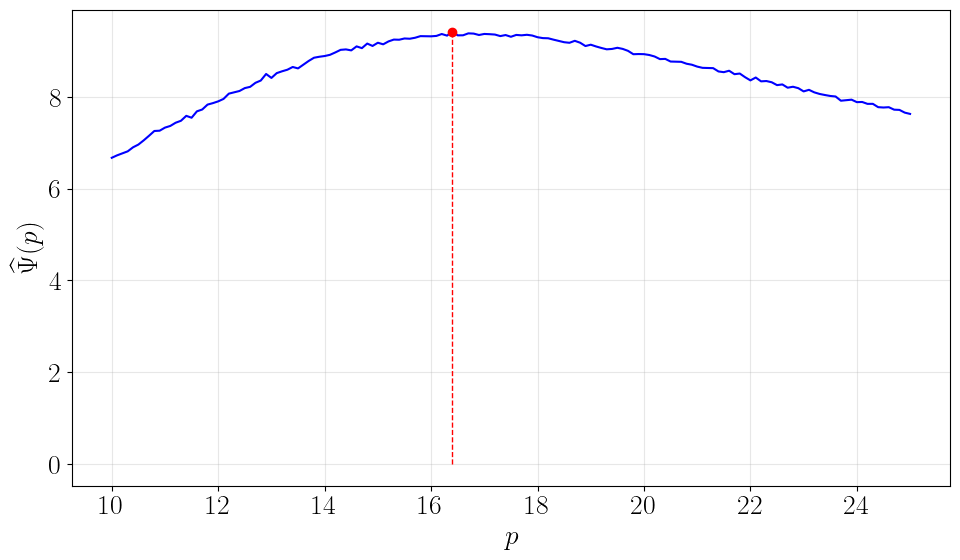

Optimal price =  16.4
Optimal revenue =  9.425410333973563


In [11]:
true_model_vars = [20, 0.1, 0.2]
price_range = np.linspace(10, 25, 151)

## Plots
output = empirical_optimal_price(true_model_vars, price_range)

optimal_price = output[0]
average_revenue_list = output[1]
optimal_revenue = average_revenue_list[np.where(price_range == optimal_price)[0][0]]

print("Optimal price = ", optimal_price)
print("Optimal revenue = ", optimal_revenue)

# optimal_price = 26.6

In [ ]:
# Rough

# var = np.random.exponential(2.0/3.0, 10000)
# var = np.random.gamma(4.0, 3.0, 10000)
var = [generate_service_time([0.5, 3.0]) for i in range(10000)]

print(np.mean(var))